# 0.0 Business Problem

Como um Consultor de Ciência de Dados para criar um modelo de alta precisão e acurácia na detecção de fraudes de transações feitas através de dispositivos móveis.

Entregaveis da consultoria:

- Modelo em produção com API.
- Relatório reportando a performance e os resultados do seu modelo em relação ao lucro e prejuízo que a empresa terá ao usar o modelo que você produziu.

  No seu relatório deve conter as respostas para as seguintes perguntas:

 -   Qual a Precisão e Acurácia do modelo?
 -   Qual a Confiabilidade do modelo em classificar as transações como legítimas ou fraudulentas?
 -   Qual o Faturamento Esperado pela Empresa se classificarmos 100% das transações com o modelo?
 -   Qual o Prejuízo Esperado pela Empresa em caso de falha do modelo?
 -   Qual o Lucro Esperado pela Blocker Fraud Company ao utilizar o modelo?

Data source: [Link](https://www.kaggle.com/ntnu-testimon/paysim1)

# 0.1 Imports

In [24]:
# Importings
import pandas as pd
import numpy as np

# Data Viz
import seaborn as sns
import matplotlib.pyplot as plt

# General Librarys
from MyToolBox import MyToolBox
from IPython.display import Image
from IPython.core.display import HTML

In [25]:
# Helper Functions  trans_fraud_data.csv

def get_data(path, target, kind='train'):
    if kind == 'train':
        train = pd.read_csv(path)
        X = train.drop(target, axis=1)
        y = train[target]
    else:
        test = pd.read_csv(path)
        X = test.copy()

    return train, X, y

def balanced_target(target, dataset, hue=None):
    """
    Function to check the balancing of the target variable.

    :target:  An pd.Series of the target variable that will be checked.
    :dataset: An Dataframe object. 
    """
    sns.set(style='darkgrid', palette='Accent')
    ax = sns.countplot(x=target, hue=hue, data=dataset)
    ax.figure.set_size_inches(10, 6)
    ax.set_title('Target Distribution', fontsize=18, loc='center')
    ax.set_xlabel(target, fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax=ax

def hipo_test(*samples):

    samples = samples

    try:
        if len(samples) == 2:
            stat, p = ttest_ind(*samples)
        elif len(samples) > 2:
            stat, p = f_oneway(*samples)
    except:
        raise Exception("Deve ser fornecido pelo menos duas samples!!!")

    if p < 0.05:
        print(f'O valor de p é: {p}')
        print('Provável haver diferença')
    else:
        print(f'O valor de p é: {p}')
        print('Provável que não haja diferença')

    return stat, p

# 1.0 Collect Data

In [26]:
train, X, y = get_data(path='../data/trans_fraud_data.csv', target='isFraud')
print(f'Quantidade de Colunas {train.shape[1]}')
print(f'Quantidade de Observações {train.shape[0]}')
train.head()

Quantidade de Colunas 11
Quantidade de Observações 6362620


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# 2.0 Data Description

- Não possuimos missing values.
- Bastante desbalanciado.
- isFlaggedFraud possui somente 16 observações,as quais também estão como positivas em isFraud, podemos nos desfazer dessa variável.
- Criar a variável type_dest e excluir nameOrig e nameDest.

In [27]:
pd.DataFrame({'missingPerc': train.isna().mean(),
              'uniques': train.nunique(),
              '%uniquePerc': (train.nunique()/train.shape[0])*100,
              'data_types': train.dtypes})

,missingPerc,uniques,%uniquePerc,data_types
step,0.0,743,0.011678,int64
type,0.0,5,0.000079,object
amount,0.0,5316900,83.564632,float64
nameOrig,0.0,6353307,99.853629,object
oldbalanceOrg,0.0,1845844,29.010753,float64
newbalanceOrig,0.0,2682586,42.161657,float64
nameDest,0.0,2722362,42.786808,object
oldbalanceDest,0.0,3614697,56.811455,float64
newbalanceDest,0.0,3555499,55.881052,float64
isFraud,0.0,2,0.000031,int64


## 2.1 isFraud vs isFlaggedFraud

Quantidade de eventos positivos - isFraud- 8213
Percentual de eventos positivos - isFraud- 0.12908204481801522

Quantidade de eventos positivos - isFlaggedFraud- 16
Percentual de eventos positivos - isFlaggedFraud- 0.12908204481801522



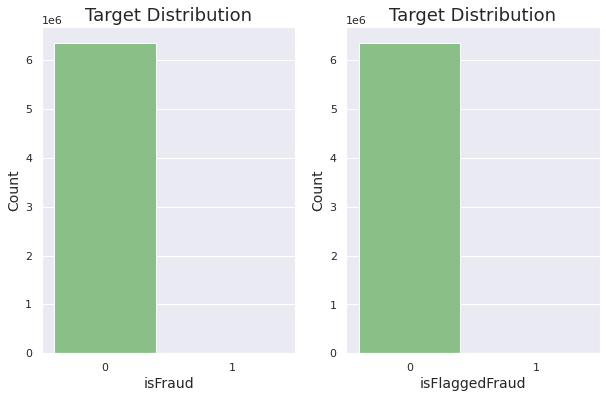

In [28]:
quant = train['isFraud'].sum()
perc = (quant/train.shape[0])*100
print(f'Quantidade de eventos positivos - isFraud- {quant}')
print(f'Percentual de eventos positivos - isFraud- {perc}\n')

quant1 = train['isFlaggedFraud'].sum()
perc1 = (quant/train.shape[0])*100
print(f'Quantidade de eventos positivos - isFlaggedFraud- {quant1}')
print(f'Percentual de eventos positivos - isFlaggedFraud- {perc1}\n')


#Plots
plt.subplot(1,2,1)
balanced_target('isFraud', dataset=train)

plt.subplot(1,2,2)
balanced_target('isFlaggedFraud', dataset=train)

# 2.2 isFlaggedFraud

In [29]:
dadosTemp = train.loc[train['isFlaggedFraud']==1,]
dadosTemp

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


# 2.3 Amount

In [30]:
train.loc[train['isFraud'] == 1,'amount'].describe().T

count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

# 2.3 Outras variáveis 
- Operações com destino tipo 'Merchant' tanto old quanto newbalance é igual a 0.

In [31]:
# Describe
variables = ['step', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
train[variables].describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.0,239.000,3.350000e+02,7.430000e+02
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.0,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.0,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.0,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.0,214661.440,1.111909e+06,3.561793e+08


In [32]:
# Percentual de operações amount != de zero oldBalanceDest e newBalanceDest são iguais a 0
quant_dest = train.loc[(train['amount'] != 0) & (train['oldbalanceDest'] == 0) & (train['newbalanceDest'] == 0), ]

perc_quant_dest = round(quant_dest.shape[0]/train.shape[0], 2)*100
print(f'O percentual de casos onde o amount é diferente de 0 com oldbalanceDest e newbalanceDest iguais {perc_quant_dest}%')

O percentual de casos onde o amount é diferente de 0 com oldbalanceDest e newbalanceDest iguais 36.0%


In [33]:
quant_dest.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
5,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0


In [34]:
# Percentual de operações amount != de zero oldBalanceOrig e newBalanceOrig são iguais a 0

quant_orig = train.loc[(train['amount'] != 0) & (train['oldbalanceOrg'] == 0) & (train['newbalanceOrig'] == 0), ]

perc_quant_orig = round(quant_orig.shape[0]/train.shape[0], 2)*100
print(f'O percentual de casos onde o amount é diferente de 0 com oldbalanceDest e newbalanceDest iguais {perc_quant_orig}%')

O percentual de casos onde o amount é diferente de 0 com oldbalanceDest e newbalanceDest iguais 33.0%


In [35]:
quant_orig.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
29,1,PAYMENT,9920.52,C764826684,0.0,0.0,M1940055334,0.0,0.0,0,0
30,1,PAYMENT,3448.92,C2103763750,0.0,0.0,M335107734,0.0,0.0,0,0
31,1,PAYMENT,4206.84,C215078753,0.0,0.0,M1757317128,0.0,0.0,0,0
32,1,PAYMENT,5885.56,C840514538,0.0,0.0,M1804441305,0.0,0.0,0,0
33,1,PAYMENT,5307.88,C1768242710,0.0,0.0,M1971783162,0.0,0.0,0,0


# 3.0 Mapa de Hipoteses

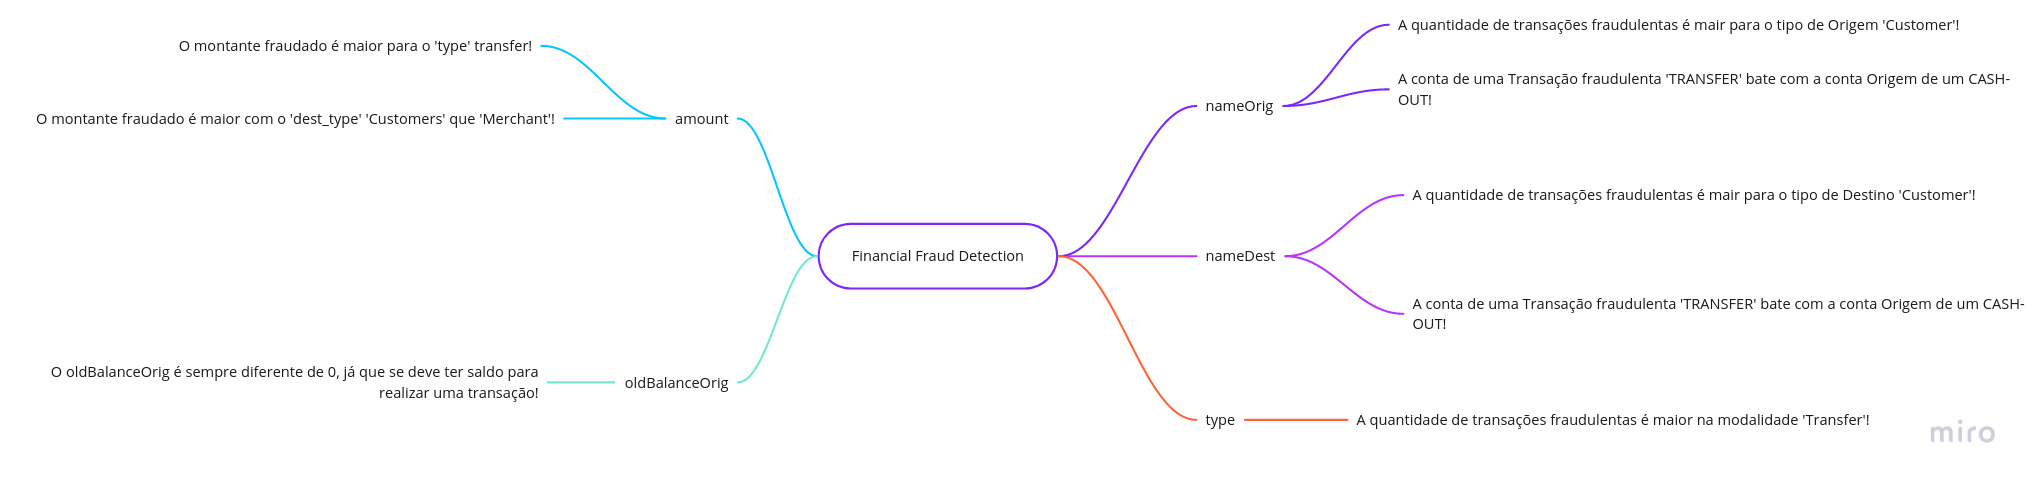

In [36]:
Image("../img/map_mental.jpg")

# 4.0 Feature Engineering

In [42]:
# copy
treino = train.copy()

# dest_type
treino['dest_type'] = treino['nameDest'].apply(lambda x: 'Merchant' if x[0] == 'M' else 'Customer')

# error_transaction
treino['error_transaction'] = treino['amount'] - (treino['oldbalanceOrg'] - treino['newbalanceOrig'])

# amount/step
treino['amount_step'] = treino['amount']/treino['step']

# Dropping 'isFlaggedFraud'
treino = treino.drop(['isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)

In [39]:
erro_acima_0 = treino.loc[treino['error_transaction'] != 0, ]

In [41]:
perc_error = round(erro_acima_0.shape[0]/train.shape[0]*100, 2)
print(f'O percentual de transações com erro são de {perc_error}')

O percentual de transações com erro são de 93.08


# 5.0 EDA

Lista de Hipoteses!

1. O montante fraudado é maior para o 'type' transfer!
2. O percentual de error_transaction é maior que 50%!
3. O montante fraudado é maior com o 'dest_type' Customers que Merchant!
4. O oldbalanceOrig é sempre diferente de 0, já que se deve ter saldo para realizar uma transação!
5. A quantidade de transações fraudulentas é maior para o tipo de Origem 'Customer'!
6. A conta de uma transação fraudulenta 'TRANSFER' bate com a conta Origem de um CASH-OUT!
7. A quantidade de transações fraudulentas é maior para o tipo de destino 'Customer'
8. A conta de uma transação fruadulenta 'TRANSFER' bate com a conta Origem de uma CASH-OUT!
9. A quantidade de transações fraudulentas é maior na modalidade 'TRANSFER'!

# 5.1 Análise Univariada

# 5.2 Análise Multivariada

# 5.3 Hipoteses

### 5.3.1 H1 O montante fraudado é maior para o 'type' TRANSFER!

### 5.3.2 H2 O percentual de error_transaction é maior que 50%!

In [46]:
# Erro
erro_acima_0 = treino.loc[treino['error_transaction'] != 0, ]

#Percentual do erro sobre dataset
perc_error = round(erro_acima_0.shape[0]/train.shape[0]*100, 2)
print(f'O percentual de transações com erro são de {perc_error}')

O percentual de transações com erro são de 93.08
